In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Function
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import random
from PIL import Image

from skimage.io import imsave, imread
from skimage.transform import resize
from skimage.transform import rotate
import h5py
import argparse

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd '/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data'

/content/gdrive/My Drive/Colab Notebooks/Segmentation/Data


<h2> 1. Data Preprocessing

In [0]:
hf = h5py.File('Brain_classification.h5', 'r')
[key for key in hf.keys()]

['imgs', 'labels']

In [0]:
imgs = hf.get('imgs')
labels = hf.get('labels')

In [0]:
imgs.shape

(3929, 256, 256)

In [0]:
labels.shape

(3929,)

In [0]:
img_rows = 96
img_cols = 96

def imgs_resize(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_rows, img_cols), preserve_range=True)

    return imgs_p

In [0]:
def norm_imgs(imgs):
  imgs = imgs.astype('float32')
  mean = np.mean(imgs)
  std = np.std(imgs)
  
  imgs -= mean
  imgs /= std
  
  return imgs

In [0]:
imgs = imgs_resize(imgs)
labels = np.array(labels, dtype=np.float32)

In [0]:
imgs.shape

(3929, 96, 96)

In [0]:
labels.shape

(3929,)

In [0]:
imgs = norm_imgs(imgs)

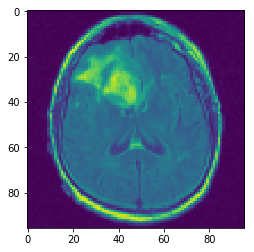

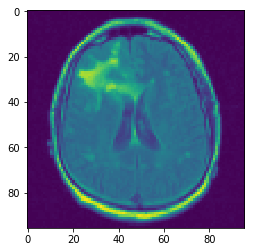

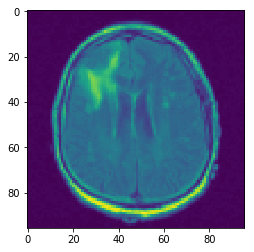

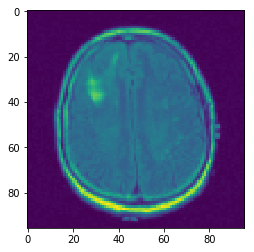

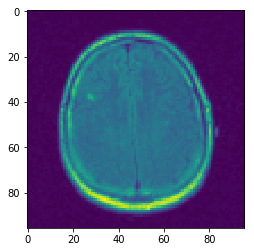

In [0]:
for i in range(5,10):
  plt.figure()
  plt.imshow(imgs[i])

In [0]:
for i in range(5,10):
  print(labels[i])

1.0
1.0
1.0
1.0
1.0


In [0]:
# Expand Dims
imgs = imgs[..., np.newaxis]
labels = labels[..., np.newaxis]

In [0]:
imgs.shape

(3929, 96, 96, 1)

In [0]:
labels.shape

(3929, 1)

In [0]:
# Channel first
imgs = imgs.transpose(0, 3, 1, 2) # C x H x W format

In [0]:
# Numpy to tensor
imgs = torch.from_numpy(imgs)
labels = torch.from_numpy(labels)

In [0]:
imgs_train = imgs[:3000]
labels_train = labels[:3000]

imgs_val = imgs[3000:3400]
labels_val = labels[3000:3400]

imgs_test = imgs[3400:]
labels_test = labels[3400:]

In [0]:
imgs_train = TensorDataset(imgs_train, labels_train)
imgs_val = TensorDataset(imgs_val, labels_val)
imgs_test = TensorDataset(imgs_test, labels_test)

<h2> 2. Model Architecture

In [0]:
# from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class CNN(nn.Module):
    
    def __init__(self, model_mode, in_channels):
        super(CNN, self).__init__()
        
        self.layers = self.make_layers(model_mode, in_channels)
        self.classifier = nn.Sequential(nn.Linear(4608, 512), nn.ReLU(), nn.Linear(512, 1), nn.Sigmoid())
        
    def make_layers(self, model_mode, in_channels):
        layers = nn.ModuleList()
        for x in cfg[model_mode]:
            if x != 'M':
                layers.append(nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, stride=1, padding=1))
                layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU())
                in_channels = x
            else :
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                
        return layers
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            #print(x.size())
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [0]:
def dimension_check():
    net = CNN('vgg16', 1)
    x = torch.randn(32, 1, 96, 96)
    y = net(x)
    print(y.size())

In [0]:
dimension_check()

torch.Size([32, 1])


In [0]:
parse = argparse.ArgumentParser()
args = parse.parse_args("")

args.device  = 'cuda' if torch.cuda.is_available() else 'cpu'
args.act = 'relu'
args.optim = 'Adam'
args.lr = 0.001
args.l2 = 0.00001
args.epoch = 30
args.train_batch_size = 32
args.val_batch_size = 32
args.test_batch_size = 32


model = CNN('vgg16', 1).to(args.device)

if args.optim == 'Adam':
    op = optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.l2)
elif args.optim == 'RMSprop':
    op = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
else:
    raise ValueError('Optimiser Error!!')
    
criterion = nn.BCELoss()

parts = {'train':imgs_train, 'val':imgs_val}

<h2> 3. Train & Evaluation Functions

In [0]:
def train(model, op, criterion, args):
    for epoch in range(args.epoch):
        for part in parts:
            loss_sum = 0
            if part == 'train':
                loader = torch.utils.data.DataLoader(parts['train'], batch_size=args.train_batch_size, shuffle = True, num_workers=2)
                model.train()
            else:
                loader = torch.utils.data.DataLoader(parts['val'], batch_size=args.val_batch_size, shuffle = True, num_workers=2)
                model.eval()
                
            for Inputs, Labels in loader:
                Inputs = Variable(Inputs.to(args.device))
                Labels = Variable(Labels.to(args.device))
                
                Outputs = model(Inputs)
            
                # 1개의 원소를 가진 Tensor를 Python의 Scalar로 만들 때는 .item()함수를 사용한다.
                loss = criterion(Outputs, Labels)
                
                loss_sum += loss.item()
                
                op.zero_grad()    
                if part == 'train':
                    loss.backward()
                    op.step()
            print('{} - epoch : {}, loss : {}'.format(part, epoch+1, loss_sum/len(loader)))

In [0]:
train(model, op, criterion, args)

train - epoch : 1, loss : 0.6225055934900933
val - epoch : 1, loss : 0.7829033549015338
train - epoch : 2, loss : 0.4611501820543979
val - epoch : 2, loss : 0.4497893017071944
train - epoch : 3, loss : 0.4519242955015061
val - epoch : 3, loss : 0.4780101294700916
train - epoch : 4, loss : 0.44297255512247696
val - epoch : 4, loss : 0.6153752414079813
train - epoch : 5, loss : 0.4270798814423541
val - epoch : 5, loss : 0.44461880968167233
train - epoch : 6, loss : 0.4216187431457195
val - epoch : 6, loss : 0.5619997932360723
train - epoch : 7, loss : 0.4049319529787023
val - epoch : 7, loss : 0.3546611208182115
train - epoch : 8, loss : 0.3605201849912075
val - epoch : 8, loss : 0.4110180322940533
train - epoch : 9, loss : 0.2969417766212149
val - epoch : 9, loss : 0.3694857611105992
train - epoch : 10, loss : 0.28301980837862545
val - epoch : 10, loss : 0.3468393454184899
train - epoch : 11, loss : 0.2667058196632152
val - epoch : 11, loss : 0.2572278265769665
train - epoch : 12, loss 

In [0]:
# save
Path = './weight_classification_v1.pt'
torch.save(model.state_dict(), Path)

In [0]:
from torchvision.transforms import RandomCrop, Compose, ToPILImage


Results = []
Labels = []
testloader = torch.utils.data.DataLoader(imgs_test, batch_size=args.test_batch_size, shuffle = False, num_workers=2)
model.eval()

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.to(args.device)
    labels = labels.to(args.device)
    
    outputs = model(images)
    Results.extend(outputs.cpu().numpy().transpose(1,0)[0])
    Labels.extend(labels.cpu().numpy().transpose(1,0)[0])

In [0]:
score_values = np.array(Results)[..., np.newaxis]
labels = np.array(Labels)[..., np.newaxis]

In [0]:
from sklearn.metrics import roc_curve, auc # roc curve tools

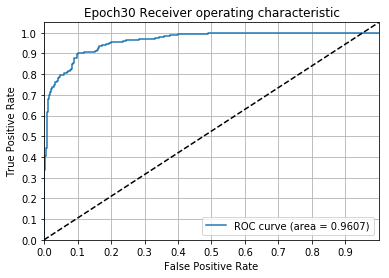

In [0]:
fpr, tpr, _ = roc_curve(labels,score_values)
roc_auc = auc(fpr,tpr)
    
fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
ax.plot([0, 1], [0, 1.05], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xticks(np.arange(0.0, 1.0, 0.1))
ax.set_yticks(np.arange(0.0, 1.05, 0.1))
ax.grid()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Epoch30 Receiver operating characteristic')
ax.legend(loc="lower right")

In [0]:
labels[0:10]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [0]:
score_values[0:10]

array([[1.0445015e-10],
       [9.9999976e-01],
       [3.0118585e-09],
       [2.6844364e-11],
       [9.9999976e-01],
       [9.9999976e-01],
       [9.9999976e-01],
       [9.9999976e-01],
       [9.9999976e-01],
       [3.7911151e-16]], dtype=float32)

In [0]:
a

In [0]:
b